In [1]:
cd /home/ubuntu/DistMEC/

/home/ubuntu/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os
import numpy as np

In [3]:
regret_rsv_dict_list = []
regret_worst_dict_list = []
regret_central_dict_list = []
regret_cstat_dict_list = []
coll_rsv_dict_list = []
coll_worst_dict_list = []

regret_worst_nc_dict_list = []
coll_worst_nc_dict_list = []

reward_rsv_dict_list = []
reward_central_dict_list = []

# System Parameters
T = 20000
num_users_list = [3,5,10,15]
num_svrs_list = [3,5,10,15]
num_locs = 9
# mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
ceiling = 40
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
space_1d_dim = 10 #4 for small, 10 for big
svr_offset_uniform = 2
max_dist = 8

num_explore = 1
trials = 5

# result dictionaries
result_dicts = []
performance_list = []
user_dicts = []

save_name = 'results/22_06_16_ceiling_20/'
isExist = os.path.exists(save_name)
if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(save_name)


# Generate visitng locations and server locations
usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs,offset = 1.7)
# svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs,offset = 1.7)

with open('traces_P_40k.pkl', 'rb') as handle:
    P_collection = pickle.load(handle)
    
with open('traces_P_40k_dict.pkl', 'rb') as handle:
    P_dict = pickle.load(handle)

In [4]:
for zt in range(len(num_svrs_list)):
    num_users = num_users_list[zt]
    num_svrs = num_svrs_list[zt]
    # Recording Mechanism
    regret_centralized_dict = {}

    regret_worst_dict = {}
    collisions_worst_dict = {}
    regret_worst_nc_dict = {}
    collisions_worst_nc_dict = {}

    regret_rsv_dict = {}
    collisions_rsv_dict = {}

    regret_cent_stat = {}
    
    reward_rsv_dict = {}
    reward_central_dict = {}
    
    mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])


    for tri in range(trials):

        # Build artificial P --> 0.95 Self transition, 0.05/S-1 other transitions
        P = np.zeros(P_collection.shape)

        temp_pm = 0.05

        for i in range(P.shape[0]):
            for j in range(P.shape[0]):
                if i != j:
                    P[i,j] = temp_pm/(P.shape[0]-1)
                else:
                    P[i,j] = 1-temp_pm


        svr_locs = gen_rand_locs(space_1d=space_1d_dim - svr_offset_uniform, nums=num_svrs)
#         svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs,offset = 1.7)
        # Create Users
        Users_w = []
        for i in range(num_users):
#             P_temp = P_collection
            Users_w += [User(usr_locs,svr_locs,mu[i],i,
                          max_dist = max_dist, threshold_dist = 6, self_weight = 0.95,
                             P = P, ceiling = 1, sticky_mode = True, kick_mode=True)]
#         Users_w_nc = []
#         for i in range(num_users):
#             Users_w_nc += [User(usr_locs,svr_locs,mu[i],i,
#                           max_dist = 1000000, threshold_dist = 6, self_weight = 0.95,
#                              P = P, ceiling = 1, sticky_mode = True, kick_mode=True)]
        

        # Create Servers
        Servers = []
        for i in range(num_svrs):
            Servers += [Server(svr_locs[i],mu,i)]

        # Recorded Values - reservation
        regret_g = np.zeros(T) # Got
        collision_count_g = np.zeros(T)
        optimal_reward_g = np.zeros(T)

        regret_w = np.zeros(T) # Worst
        collision_count_w = np.zeros(T)
        optimal_reward = np.zeros(T)
        
        regret_w_nc = np.zeros(T)
        collision_count_w_nc = np.zeros(T)

        # Explore rounds are common/shared across all users
        explore_rounds(Users_w, num_users, Servers, mu, regret_w, collision_count_w, optimal_reward,
                       usr_move_flag = True, rounds=num_explore)
#         explore_rounds(Users_w_nc, num_users, Servers, mu, regret_w_nc, collision_count_w_nc, optimal_reward,
#                        usr_move_flag = True, rounds=num_explore)



        round_start = ((num_svrs)*num_explore)+1


        # Other reward recodings
        Users_rsv = copy.deepcopy(Users_w)
        regret_rsv = copy.deepcopy(regret_w)
        collision_count_rsv = copy.deepcopy(collision_count_w)
        for u in Users_rsv:
            u.sticky_mode = True
            u.kick_mode = True #false
            u.ceiling = ceiling
            u.expected_time_true = u.get_expected_time()
            


        # Centralized - true w learning
        rewards_record_ct, pulls_record_ct, ucb_ct = extract_centralized_case(Users_w, num_users, num_svrs)
        regret_ct = copy.deepcopy(regret_w)

        # Centralized - stationary w learning
        rewards_record_cs, pulls_record_cs, ucb_cs = extract_centralized_case(Users_w, num_users, num_svrs)
        regret_cs = copy.deepcopy(regret_w)

        # Centralized - stationary w, known mu
        w_stat = obtain_w_stationary(Users_w, num_users, num_svrs)
        optimal_stat_arms = offline_optimal_action(w_stat,mu)[0]
        regret_cst = copy.deepcopy(regret_w)

        for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):
            w = obtain_w(Users_w, len(Users_w), len(Servers))
            optimal = offline_optimal_action(w, mu)
            optimal_reward[t] = optimal[1]

            # Distributed solution 
            play_round(Users_w, Servers, mu, regret_w, collision_count_w, 
                       usr_move_flag = True, debugger = False, reservation_mode = True, optimal =optimal)
            play_round(Users_rsv, Servers, mu, regret_rsv, collision_count_rsv, 
                       usr_move_flag = False, debugger = False, reservation_mode = True, optimal =optimal, t = t)
#             play_round(Users_w_nc, Servers, mu, regret_w_nc, collision_count_w_nc, 
#                        usr_move_flag = False, debugger = False, reservation_mode = True, optimal =optimal, w = w)
            copy_usr_loc(Users_w, Users_rsv)
#             copy_usr_loc(Users_w, Users_w_nc)


            # Centralized Solution -  true w learning
            ucb_ct = update_ucb(rewards_record_ct, pulls_record_ct, ucb_ct, t, 1)
            arms = offline_optimal_action(w, ucb_ct)[0]
            rewards_record_ct, pulls_record_ct = pull_super_arm(arms, mu, rewards_record_ct, pulls_record_ct)
            regret_ct[t] = optimal[1] - expected_reward(arms, mu, w)

            # Centralized Solution -  stationary w learning
            ucb_cs = update_ucb(rewards_record_cs, pulls_record_cs, ucb_cs, t, 1)
            arms = offline_optimal_action(w_stat, ucb_cs)[0]
            rewards_record_cs, pulls_record_cs = pull_super_arm(arms, mu, rewards_record_cs, pulls_record_cs)
            regret_cs[t] = optimal[1] - expected_reward(arms, mu, w)


        regret_centralized_dict[tri] = copy.deepcopy(regret_ct)

        regret_worst_dict[tri] = copy.deepcopy(regret_w)
        collisions_worst_dict[tri] = copy.deepcopy(collision_count_w)
        
#         regret_worst_nc_dict[tri] = copy.deepcopy(regret_w_nc)
#         collisions_worst_nc_dict[tri] = copy.deepcopy(collision_count_w_nc)

        regret_rsv_dict[tri] = copy.deepcopy(regret_rsv)
        collisions_rsv_dict[tri] = copy.deepcopy(collision_count_rsv)

        regret_cent_stat[tri] = copy.deepcopy(regret_cs)
#         regret_opt_stat[tri] = copy.deepcopy(regret_cst)

        reward_rsv_dict[tri] = optimal_reward - regret_rsv
        reward_central_dict[tri] = optimal_reward - regret_ct


        del Users_w, Users_rsv, Servers
    regret_rsv_dict_list += [regret_rsv_dict]
    regret_worst_dict_list += [regret_worst_dict]
    regret_central_dict_list += [regret_centralized_dict]
    regret_cstat_dict_list += [regret_cent_stat]
    coll_rsv_dict_list += [collisions_rsv_dict]
    coll_worst_dict_list += [collisions_worst_dict]
    
    reward_rsv_dict_list += [reward_rsv_dict]
    reward_central_dict_list += [reward_central_dict]

#     regret_worst_nc_dict_list += [regret_worst_nc_dict]
#     coll_worst_nc_dict_list += [collisions_worst_nc_dict]

<ipython-input-4-ac0fc1d6eb75>:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):


In [5]:
type(np.array([]))

numpy.ndarray

In [6]:
save_dict = {}
save_dict['regret_rsv_dict_list'] = regret_rsv_dict_list
save_dict['regret_worst_dict_list'] = regret_worst_dict_list
save_dict['regret_central_dict_list'] = regret_central_dict_list
save_dict['regret_cstat_dict_list'] = regret_cstat_dict_list
save_dict['coll_rsv_dict_list'] = coll_rsv_dict_list
save_dict['coll_worst_dict_list'] = coll_worst_dict_list

save_dict['reward_rsv_dict_list'] = reward_rsv_dict_list
save_dict['reward_central_dict_list'] = reward_central_dict_list


# save_dict['regret_worst_nc_dict_list'] = regret_worst_nc_dict_list
# save_dict['coll_worst_nc_dict_list'] = coll_worst_nc_dict_list


with open("experiments/save/exp8/220726_run1_t5.pkl", "wb") as tf:
    pickle.dump(save_dict,tf)

In [4]:
with open("experiments/save/exp8/220726_run1_t5.pkl", "rb") as handle:
    load_dict = pickle.load(handle)
    
regret_rsv_dict_list = load_dict['regret_rsv_dict_list']
regret_worst_dict_list = load_dict['regret_worst_dict_list']
regret_central_dict_list = load_dict['regret_central_dict_list']
regret_cstat_dict_list = load_dict['regret_cstat_dict_list']

coll_rsv_dict_list = load_dict['coll_rsv_dict_list']
coll_worst_dict_list = load_dict['coll_worst_dict_list']

reward_rsv_dict_list = load_dict['reward_rsv_dict_list']
reward_central_dict_list = load_dict['reward_central_dict_list']

# regret_worst_nc_dict_list = load_dict['regret_worst_nc_dict_list']
# coll_worst_nc_dict_list = load_dict['coll_worst_nc_dict_list']

In [5]:
dist_times = [0.000108245, 0.000103099, 0.00011367, 0.00012864]
central_times = [0.007643564, 0.009094647, 0.016291809, 0.029092328]

In [6]:
nt = trials
cc = len(num_svrs_list)

# calculating error bars
regret_worst_sd = np.zeros([cc,nt])
regret_rsv_sd = np.zeros([cc, nt])
regret_cent_stat_sd = np.zeros([cc, nt])
regret_centralized_sd = np.zeros([cc, nt])

collisions_worst_sd = np.zeros([cc,nt])
collisions_rsv_sd = np.zeros([cc, nt])

reward_rsv_sd = np.zeros([cc,nt])
reward_central_sd = np.zeros([cc,nt])

for i in range(cc):
    for j in range(nt):
        regret_worst_sd[i,j] = np.cumsum(regret_worst_dict_list[i][j])[-1]
        regret_rsv_sd[i,j] = np.cumsum(regret_rsv_dict_list[i][j])[-1]
        regret_cent_stat_sd[i,j] = np.cumsum(regret_cstat_dict_list[i][j])[-1]
        regret_centralized_sd[i,j] = np.cumsum(regret_central_dict_list[i][j])[-1]
        
        collisions_worst_sd[i,j] = np.cumsum(coll_worst_dict_list[i][j])[-1]/(T * i)
        collisions_rsv_sd[i,j] = np.cumsum(coll_rsv_dict_list[i][j])[-1]/(T*i)
        
        reward_rsv_sd[i,j] = np.cumsum(reward_rsv_dict_list[i][j])[-1]/(num_svrs_list[i] * 1e3 * dist_times[i])
        reward_central_sd[i,j] = np.cumsum(reward_central_dict_list[i][j])[-1]/(num_svrs_list[i]* 1e3 * central_times[i])

regret_worst_sd2 = np.sqrt(regret_worst_sd.var(1))
regret_rsv_sd2 = np.sqrt(regret_rsv_sd.var(1))
regret_cent_stat_sd2 = np.sqrt(regret_cent_stat_sd.var(1))
regret_centralized_sd2 = np.sqrt(regret_centralized_sd.var(1))
collisions_worst_sd2 = np.sqrt(collisions_worst_sd.var(1))
collisions_rsv_sd2 = np.sqrt(collisions_rsv_sd.var(1))

reward_rsv_sd2= np.sqrt(reward_rsv_sd.var(1))
reward_central_sd2 = np.sqrt(reward_central_sd.var(1))
        
x = num_svrs_list
regret_rsv_plot = []
regret_worst_plot = []
regret_central_plot = []
regret_cstat_plot = []

reward_central_plot = []
reward_rsv_plot = []

for zt in range(len(num_svrs_list)):
    
    regret_rsv_avg = 1/trials * regret_rsv_dict_list[zt][0]
    regret_worst_avg= 1/trials * regret_worst_dict_list[zt][0]
    regret_centralized_avg = 1/trials * regret_central_dict_list[zt][0]
    regret_cent_stat_avg= 1/trials * regret_cstat_dict_list[zt][0]

    reward_centralized_avg = 1/trials * reward_central_dict_list[zt][0]
    reward_rsv_avg = 1/trials * reward_rsv_dict_list[zt][0]
    
    for i in range(1, trials):

        regret_rsv_avg += 1/trials * regret_rsv_dict_list[zt][i]
        regret_worst_avg += 1/trials * regret_worst_dict_list[zt][i]
        regret_centralized_avg += 1/trials * regret_central_dict_list[zt][i]
        regret_cent_stat_avg += 1/trials * regret_cstat_dict_list[zt][i]
        
        reward_centralized_avg += 1/trials * reward_central_dict_list[zt][i]
        reward_rsv_avg += 1/trials * reward_rsv_dict_list[zt][i]
    
    regret_rsv_plot += [copy.deepcopy(np.cumsum(regret_rsv_avg)[-1])]
    regret_worst_plot += [copy.deepcopy(np.cumsum(regret_worst_avg)[-1])]
    regret_central_plot += [copy.deepcopy(np.cumsum(regret_centralized_avg)[-1])]
    regret_cstat_plot += [copy.deepcopy(np.cumsum(regret_cent_stat_avg)[-1])]
    
    reward_central_plot += [np.cumsum(reward_centralized_avg)[-1]/ num_svrs_list[zt]]
    reward_rsv_plot += [np.cumsum(reward_rsv_avg)[-1]/ num_svrs_list[zt]]

<ipython-input-6-70bae4206dae>:23: RuntimeWarning: divide by zero encountered in double_scalars
  collisions_worst_sd[i,j] = np.cumsum(coll_worst_dict_list[i][j])[-1]/(T * i)
<ipython-input-6-70bae4206dae>:24: RuntimeWarning: divide by zero encountered in double_scalars
  collisions_rsv_sd[i,j] = np.cumsum(coll_rsv_dict_list[i][j])[-1]/(T*i)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


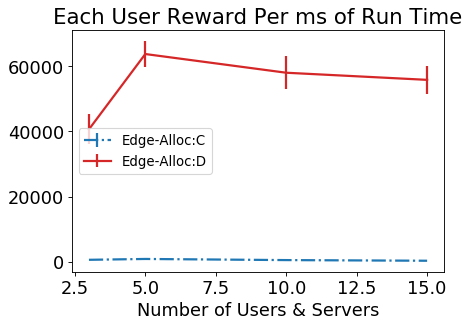

In [11]:
# Load times
dist_times = [0.000108245, 0.000103099, 0.00011367, 0.00012864]
central_times = [0.007643564, 0.009094647, 0.016291809, 0.029092328]

plt.figure(figsize=(6, 4), dpi=80)
# Calculate from equation

plt.errorbar(x,np.divide(reward_central_plot, central_times) / 1e3, reward_central_sd2, label = "Edge-Alloc:C", color = "tab:blue", 
         linewidth=2.0, linestyle='dashdot')
plt.errorbar(x, np.divide(reward_rsv_plot, dist_times)/ 1e3, reward_rsv_sd2, label = "Edge-Alloc:D", 
        color = "tab:red", linewidth=2.0)

#  Set Font Size Limitations
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

# plt.yscale('log')

plt.title('Each User Reward Per ms of Run Time')
plt.xlabel('Number of Users & Servers')
plt.legend(loc = 'center left', prop={'size': 12})


In [11]:
np.divide(reward_rsv_plot, dist_times)/ 1e3

array([121962.43087153, 318756.88707621, 580160.68747486, 837482.75864064])

In [12]:
np.divide(reward_central_plot, central_times) / 1e3

array([1928.76312108, 4511.74020477, 5552.84171969, 5336.73710897])

In [30]:
reward_rsv_sd

array([[44696.89444955, 42542.72322008, 45700.917557  , 35882.99518475,
        34447.18770784],
       [65090.56344812, 60224.88198817, 65233.37763825, 58569.17981553,
        69638.88418614],
       [54686.88049851, 52577.47401726, 61362.08464849, 55310.78821811,
        66143.11635506],
       [57852.87318993, 49953.7000722 , 57668.4412324 , 61627.41113543,
        52058.49391692]])

In [35]:
reward_central_sd

array([[710.850344  , 664.73634426, 706.9528918 , 579.80018367,
        552.26543806],
       [933.56646181, 855.86217854, 923.58191856, 859.85822128,
        938.87142457],
       [534.75229574, 518.87873782, 586.19336201, 526.50406265,
        610.09240162],
       [363.17911654, 332.94578157, 362.14391893, 378.54985923,
        342.09369339]])

In [45]:
np.divide(reward_central_plot, central_times) / 1e3

array([642.92104036, 902.34804095, 555.28417197, 355.78247393])

In [46]:
np.divide(reward_rsv_plot, dist_times)/ 1e3

array([40654.14362384, 63751.37741524, 58016.06874749, 55832.18390938])

In [49]:
np.multiply(reward_central_plot, num_svrs_list)

array([ 14742.6243568 ,  41032.68451806,  90465.83670439, 155258.106424  ])

In [50]:
np.multiply(reward_rsv_plot, num_svrs_list)

array([ 13201.82332969,  32863.51630067,  65946.86534527, 107733.78207153])